# Imports

In [149]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import subprocess
import os as os
import seaborn as sns
import seaborn.objects as so
from glob2 import glob
from datetime import datetime
import pytz

import random

In [142]:
import mir_eval as me

In [143]:
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    "mM7": "minor-major-7th",
    "+7": "augmented-7th",
}

----

## Loading the Results
Loads all json files from the given folders

In [244]:
def get_all_experiments(path):
    experiments = set()
    experiment_types = set()
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                if file[6] == "-":
                    continue
                experiments.add(file.split(".")[0])
                try:
                    experiment_types.add(file.split(".")[0].split("_")[1])
                except:
                    print(file)
    return experiments, experiment_types

In [245]:
def get_experiments(experiment_name):
    cols = ['id', 'corpus', 'piece', 'algorithm', 'accuracy', 'likelihood', 'chordLabels', 'slices','runTime', 'reruns']
    df = pd.DataFrame(columns=cols) 
    lbls = pd.DataFrame(columns=["piece", "corpus", "labels"])
    
    path = "outputs"
    experiments, experiment_types = get_all_experiments(path)
    if experiment_name in experiment_types:
        print("Getting runs of {}".format(experiment_name))
    else:
        print("Can't find experiment {}".format(experiment_name))
        return 
    
    fails = [] 
    successes = 0
    lbl_list = []
    df_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if experiment_name in file:
                try:
                    if file[6] == "-":
                        #ignore old format
                        continue
                        
                    with open(os.path.join(root, file), 'r') as f:
                        data = json.loads(f.read())
                except:
                    fails.append(file)
                    continue
                
                successes += 1

                newLbls = pd.DataFrame([{"corpus":data['corpus'], "piece":data["piece"], "labels": data["groundTruth"]}])
                lbl_list.append(newLbls)

                newdf = pd.json_normalize(data, record_path = ['results'], 
                    meta = ['id','corpus', 'piece','algorithm'])
                df_list.append(newdf)
    df = pd.concat(df_list)
    lbls = pd.concat(lbl_list)
    
    df["experiment"] = df["id"].apply(lambda x: x.split("_")[1] if "_" in x else np.nan)
    df["id"] = pd.to_datetime(df["id"].apply(lambda x: x.split("_")[0] if "_" in x else np.nan))
    #df = df.dropna(subset=["experiment"])
    results = df.set_index(["id","corpus", "piece"])
    print ("Parsed {} runs succesfully, consisting of {} unique experiments with {} failed runs".format(successes, results.index.levels[0].nunique(), len(fails)))
    return (results,lbls.set_index(["corpus", "piece"]))

In [246]:
def get_latest_experiment(experiment):
    (results, groundTruth) = get_experiments(experiment)
    latest_timestamp = results.index.get_level_values(0).max()
    print("Viewing latest result: {}".format(latest_timestamp))
    return (results.loc[results.index.get_level_values(0) == latest_timestamp], groundTruth)
        

In [247]:
(results, labels) = get_experiments("dual-stochastic-res-params")

Getting runs of dual-stochastic-res-params
Parsed 198 runs succesfully, consisting of 2 unique experiments with 0 failed runs


In [248]:
(results, labels) = get_latest_experiment("dual-stochastic-res-params")

Getting runs of dual-stochastic-res-params
Parsed 198 runs succesfully, consisting of 2 unique experiments with 0 failed runs
Viewing latest result: 2023-04-17 22:29:26


# Organising results
Let's look at all experiments that have been run

In [249]:
experiments, experiment_types = get_all_experiments("outputs")

In [254]:
print(experiment_types)

{'dual-stochastic-res-params'}


# Stochastic beam search hyperparameters

### Choose specific experiement
202304-1700-0801 is the first experiment ran.
Includes 795 total runs. 
With Beam width 1-20 and reservoirs 200-4000 with gaps of 200.
Timeout was 400s, and only 72 runs completed within the time.

Next run will increase the timeout to 1000s, and narrow in the grid search region.

In [286]:
(results, labels) = get_latest_experiment("dual-stochastic-res-params")

Getting runs of dual-stochastic-res-params
Parsed 303 runs succesfully, consisting of 3 unique experiments with 0 failed runs
Viewing latest result: 2023-04-17 23:05:41


 Extract parameters from algorithm name

## Accuracy, loglikelihood and runtime

In [287]:
results['beamwidth'] = results["algorithm"].apply(lambda s: int(s.split(" ")[1]))
results['reservoirsize'] = results["algorithm"].apply(lambda s: int(s.split(" ")[2]))

def get_avgs(df, value):
    g = df.dropna(subset=value).groupby(['beamwidth','reservoirsize'])
    df_means = g[value].mean()
    return df_means.loc[:,:].reset_index().pivot(index='reservoirsize', columns='beamwidth', values=value)

acc_avgs = get_avgs(results, 'accuracy')
lik_avgs = get_avgs(results, 'likelihood')
run_avgs = get_avgs(results, 'runTime')

In [288]:
#stochastic_params_df.groupby(["piece"]).runTime.mean()

## Plot hyperparemter results

In [289]:
def create_heatmap(xs, ax, vmin, vmax,cmap):
    lbls = xs.applymap(lambda v: "{:.2f}".format(v) if v in [np.nanmax(xs.values),np.nanmin(xs.values)]else '')
    return sns.heatmap(xs,
            square=True,
            ax=ax,
            cmap=cmap,
            fmt='',
            annot=lbls, # Label the maximum value
            annot_kws={'fontsize':5},
            mask=xs.isna(),
            vmax=vmax,
            vmin=vmin,
            linewidth=0.01)

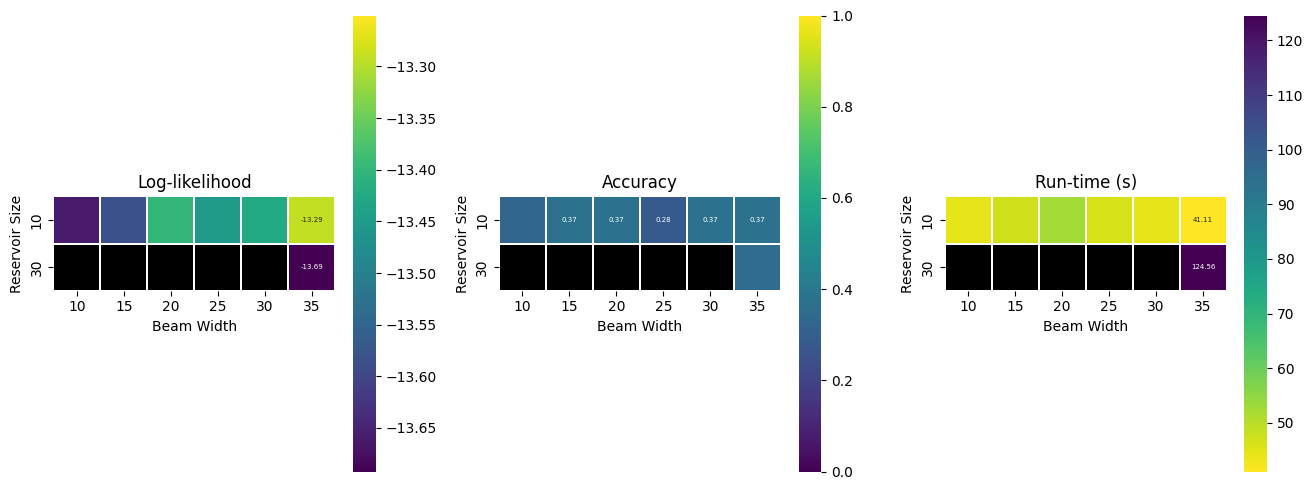

In [290]:
height=5
ratio = stochastic_params_df['reservoirsize'].nunique() / stochastic_params_df['beamwidth'].nunique()
spacing = 1
fig, ax = plt.subplots(1, 3, figsize=((height*3)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1,1]})

cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color="black")

l = create_heatmap(lik_avgs, ax[0], lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()) * 0.1, cmap)
a = create_heatmap(acc_avgs, ax[1], 0, 1, cmap)
r = create_heatmap(run_avgs, ax[2], run_avgs.min().min(), run_avgs.max().max(), cmap.reversed())

ax[0].set_title('Log-likelihood')
ax[1].set_title('Accuracy')
ax[2].set_title('Run-time (s)')

for a in ax:
    a.set_xlabel('Beam Width')
    a.set_ylabel('Reservoir Size')


plt.tight_layout()
plt.savefig('plots/stochbeamsearchgridsearch-{}.png'.format(exp_id), dpi=180)

# Stochastic beam search limited size experiment

We find that the run time increase heavily with both resovoir size and beam width. Close analysis finds that its a result of slices become very large, due to unspreads combining notes. We limit the evaluator to only applow unspreads produces slices up to size $\gamma$. For brevity, we choose a fixed reservoir size, 700.

### Choose specific experiement


In [505]:
exp_id = "202304-1715-2135"

In [506]:
exp_df = results.xs(exp_id,level=1)

In [507]:
stochastic_params_lim_df = exp_df.xs("stochastic-limited-fixed-res",level=0)

In [508]:
stochastic_params_lim_df

algorithm  accuracy  \
corpus             piece                                               
grieg_lyric_pieces op47n01   StochasticBeamSearch_13_700_2       NaN   
                   op47n01   StochasticBeamSearch_13_700_3       NaN   
                   op47n01   StochasticBeamSearch_13_700_1       NaN   
                   op12n08   StochasticBeamSearch_8_700_11  0.756410   
                   op12n08   StochasticBeamSearch_8_700_12  0.756410   
                   op12n08   StochasticBeamSearch_8_700_13  0.756410   
                   op12n02    StochasticBeamSearch_8_700_9       NaN   
                   op38n02   StochasticBeamSearch_11_700_8       NaN   
                   op38n06   StochasticBeamSearch_8_700_13       NaN   
                   op47n07   StochasticBeamSearch_13_700_3       NaN   
                   op43n06  StochasticBeamSearch_11_700_12       NaN   
                   op47n06  StochasticBeamSearch_11_700_14       NaN   
                   op43n01  StochasticBeamSearch_12_700_18       NaN   
                   op38n07   StochasticBeamSearch_10_700_2       NaN   
                   op38n07   StochasticBeamSearch_10_700_3  0.254545   
                   op38n07   StochasticBeamSearch_10_700_4  0.254545   
                   op38n03  StochasticBeamSearch_12_700_16       NaN   
                   op47n04   StochasticBeamSearch_8_700_17       NaN   
                   op54n02   StochasticBeamSearch_7_700_11       NaN   
                   op54n04   StochasticBeamSearch_10_700_8       NaN   
                   op43n04   StochasticBeamSearch_8_700_15  0.384615   
                   op43n04   StochasticBeamSearch_8_700_16  0.384615   
                   op54n03   StochasticBeamSearch_8_700_19       NaN   
                   op54n03    StochasticBeamSearch_9_700_1       NaN   
                   op12n01    StochasticBeamSearch_7_700_2       NaN   
                   op12n01    StochasticBeamSearch_7_700_1       NaN   
                   op12n01    StochasticBeamSearch_7_700_3  0.325581   
                   op12n01    StochasticBeamSearch_7_700_4  0.325581   

                            likelihood  \
corpus             piece                 
grieg_lyric_pieces op47n01         NaN   
                   op47n01         NaN   
                   op47n01         NaN   
                   op12n08  -12.441700   
                   op12n08  -12.441700   
                   op12n08  -12.441700   
                   op12n02         NaN   
                   op38n02         NaN   
                   op38n06         NaN   
                   op47n07         NaN   
                   op43n06         NaN   
                   op47n06         NaN   
                   op43n01         NaN   
                   op38n07         NaN   
                   op38n07  -12.992248   
                   op38n07  -12.945512   
                   op38n03         NaN   
                   op47n04         NaN   
                   op54n02         NaN   
                   op54n04         NaN   
                   op43n04  -13.407268   
                   op43n04  -13.407268   
                   op54n03         NaN   
                   op54n03         NaN   
                   op12n01         NaN   
                   op12n01         NaN   
                   op12n01  -13.640451   
                   op12n01  -13.640451   

                                                                  chordLabels  \
corpus             piece                                                        
grieg_lyric_pieces op47n01                                               None   
                   op47n01                                               None   
                   op47n01                                               None   
                   op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                   op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                   op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, 

 Extract parameters from algorithm name

In [509]:
stochastic_params_lim_df['beamwidth'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[1]))
stochastic_params_lim_df['limit'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[3]))

/tmp/ipykernel_66/980105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stochastic_params_lim_df['beamwidth'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[1]))
/tmp/ipykernel_66/980105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stochastic_params_lim_df['limit'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[3]))


## Accuracy, loglikelihood and runtime

In [510]:
def get_avgs(df, value):
    g = df.dropna(subset=value).groupby(['beamwidth','limit'])
    df_means = g[value].mean()
    return df_means.loc[:,:].reset_index().pivot(index='limit', columns='beamwidth', values=value)

In [511]:
acc_avgs = get_avgs(stochastic_params_lim_df, 'accuracy')
lik_avgs = get_avgs(stochastic_params_lim_df, 'likelihood')
run_avgs = get_avgs(stochastic_params_lim_df, 'runTime')

## Plot hyperparemter results

In [512]:
def create_heatmap(xs, ax, vmin, vmax,cmap):
    lbls = xs.applymap(lambda v: "{:.2f}".format(v) if v in [np.nanmax(xs.values),np.nanmin(xs.values)]else '')
    return sns.heatmap(xs,
            square=True,
            ax=ax,
            cmap=cmap,
            fmt='',
            annot=lbls, # Label the maximum value
            annot_kws={'fontsize':5},
            mask=xs.isna(),
            vmax=vmax,
            vmin=vmin,
            linewidth=0.01)

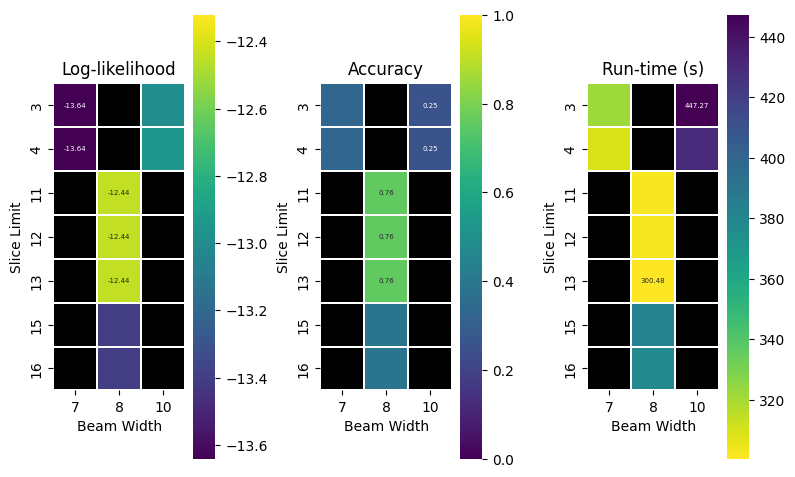

In [513]:
height=5
ratio = stochastic_params_lim_df['limit'].nunique() / stochastic_params_lim_df['beamwidth'].nunique()
spacing = 1
fig, ax = plt.subplots(1, 3, figsize=((height*3)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1,1]})

cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color="black")

l = create_heatmap(lik_avgs, ax[0], lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()) * 0.1, cmap)
a = create_heatmap(acc_avgs, ax[1], 0, 1, cmap)
r = create_heatmap(run_avgs, ax[2], run_avgs.min().min(), run_avgs.max().max(), cmap.reversed())

ax[0].set_title('Log-likelihood')
ax[1].set_title('Accuracy')
ax[2].set_title('Run-time (s)')

for a in ax:
    a.set_xlabel('Beam Width')
    a.set_ylabel('Slice Limit')


plt.tight_layout()
plt.savefig('plots/stochbeamlimgridsearch-{}.png'.format(exp_id), dpi=180)

# Analysis on latest experiment

In [514]:
results = results.drop(["id"],axis=1)

KeyError: "['id'] not found in axis"

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [ ]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).errors()

In [ ]:
agm = results.drop(["chordLabels", "slices","runTime","likelihood"], axis=1).groupby(["corpus", "algorithm"]).agg([np.std])

In [ ]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [ ]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [ ]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [ ]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

## Plot Accuracy Chart

In [ ]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#plt.ylabel('Accuracy')
#plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

# Close Error Analysis

Attributes: chord type, root note, etc

#### Zoom in on ABC: n02op18-2_03

In [ ]:
groundTruth.loc['ABC','n02op18-2_03']

In [ ]:
results

In [ ]:
ex = results.loc['schumann_kinderszenen','n04']

In [ ]:
ex[["algorithm", "accuracy", "likelihood", "runTime"]]